# Jupyter notebook for creating Liverpool Report

- some code was adapted from https://github.com/Friends-of-Tracking-Data-FoTD

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mplsoccer.pitch import Pitch
from IPython.display import display
from exGoal import scale_to_visual,calculateDistance
import math
import json
from IPython.display import display
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import cm

In [4]:
wyscout_tags = [
    (101, "goal"),
    (102, "own_goal"),
    (301, "assist"),
    (302, "key_pass"),
    (1901, "counter_attack"),
    (401, "left_foot"),
    (402, "right_foot"),
    (403, "head/body"),
    (1101, "direct"),
    (1102, "indirect"),
    (2001, "dangerous_ball_lost"),
    (2101, "blocked"),
    (801, "high"),
    (802, "low"),
    (1401, "interception"),
    (1501, "clearance"),
    (201, "opportunity"),
    (1301, "feint"),
    (1302, "missed_ball"),
    (501, "free_space_right"),
    (502, "free_space_left"),
    (503, "take_on_left"),
    (504, "take_on_right"),
    (1601, "sliding_tackle"),
    (601, "anticipated"),
    (602, "anticipation"),
    (1701, "red_card"),
    (1702, "yellow_card"),
    (1703, "second_yellow_card"),
    (1201, "position_goal_low_center"),
    (1202, "position_goal_low_right"),
    (1203, "position_goal_mid_center"),
    (1204, "position_goal_mid_left"),
    (1205, "position_goal_low_left"),
    (1206, "position_goal_mid_right"),
    (1207, "position_goal_high_center"),
    (1208, "position_goal_high_left"),
    (1209, "position_goal_high_right"),
    (1210, "position_out_low_right"),
    (1211, "position_out_mid_left"),
    (1212, "position_out_low_left"),
    (1213, "position_out_mid_right"),
    (1214, "position_out_high_center"),
    (1215, "position_out_high_left"),
    (1216, "position_out_high_right"),
    (1217, "position_post_low_right"),
    (1218, "position_post_mid_left"),
    (1219, "position_post_low_left"),
    (1220, "position_post_mid_right"),
    (1221, "position_post_high_center"),
    (1222, "position_post_high_left"),
    (1223, "position_post_high_right"),
    (901, "through"),
    (1001, "fairplay"),
    (701, "lost"),
    (702, "neutral"),
    (703, "won"),
    (1801, "accurate"),
    (1802, "not_accurate"),
]
def get_tag_set(tags):
    return {tag["id"] for tag in tags}


def get_tagsdf(events):
    tags = events.tags.apply(get_tag_set)
    tagsdf = pd.DataFrame()
    for (tag_id, column) in wyscout_tags:
        tagsdf[column] = tags.apply(lambda x: tag_id in x)
    return tagsdf

def make_new_positions(events_df):
    new_positions = events_df[["id", "positions"]].apply(
        lambda x: make_position_vars(x[0], x[1]), axis=1
    )
    new_positions.columns = ["id", "start_x", "start_y", "end_x", "end_y"]
    events_df = pd.merge(events_df, new_positions, left_on="id", right_on="id")
    events_df = events_df.drop("positions", axis=1)
    return events_df

def make_position_vars(event_id, positions):
    if len(positions) == 2:  # if less than 2 then action is removed
        start_x = positions[0]["x"]
        start_y = positions[0]["y"]
        end_x = positions[1]["x"]
        end_y = positions[1]["y"]
    elif len(positions) == 1:
        start_x = positions[0]["x"]
        start_y = positions[0]["y"]
        end_x = start_x
        end_y = start_y
    else:
        start_x = None
        start_y = None
        end_x = None
        end_y = None
    return pd.Series([event_id, start_x, start_y, end_x, end_y])

def plot_goal(ax):
#     fig, ax = plt.subplots(figsize=(13, 5))
    # fig=plt.figure()
    # ax=fig.add_subplot(1,1,1)
    # ax = plt.gca()
    ax.plot([36.3,37],[2.5,0.5],linewidth=2, color="grey", fillstyle='full') #upper left
    ax.plot([36,37],[0,0.5],linewidth=2, color="grey", fillstyle='full') #upper left
    ax.plot([43.7,43],[2.5,0.5],linewidth=2, color="grey", fillstyle='full') #upper left
    ax.plot([44,43],[0,0.5],linewidth=2, color="grey", fillstyle='full') #upper left


    ax.plot([43.7,44],[2.5,2.67],linewidth=2, color="grey", fillstyle='full') #upper left
    ax.plot([36,36.3],[2.67,2.5],linewidth=2, color="grey", fillstyle='full') #upper left

    #goal bar
    ax.plot([36,36],[0,2.67],linewidth=8, color="black") # x,x, y,y #left post
    ax.plot([44,44],[0,2.67],linewidth=8, color="black") # right post
    ax.plot([36,44],[2.67,2.67],linewidth=8, color="black") #cross bar

    ax.plot([36,36],[0,2.67],linewidth=5, color="grey") # x,x, y,y #left post
    ax.plot([44,44],[0,2.67],linewidth=5, color="grey") # right post
    ax.plot([36,44],[2.67,2.67],linewidth=5, color="grey") #cross bar

    ax.plot([37,43],[0.5,0.5],linewidth=2, color="grey") #cross bar

    ax.plot([33,47],[-0.07,-0.07],linewidth=1, color="gray") # goal line
    
    ax.set_axis_off()
    
    ax.set_ylim(-1.5, 4.0)
    ax.set_xlim(33.5, 46.5)
     
    return ax

# Data
- Read data
- Some preprocessing

In [5]:
events = pd.read_hdf('C:/FoTProjects/datasciencesoccer/liverpool_analitics/premier_league_event_data.hd',key='wyscout')

In [6]:
events_org = pd.read_hdf('C:/FoTProjects/datasciencesoccer/data/Liverpool_events.hdf', key='lp')
print(list(set(events_org['subEventName'])))
print(list(set(events_org['eventName'])))


events_org = pd.concat([events_org, get_tagsdf(events_org)], axis=1)
events_org = make_new_positions(events_org)

['', 'Ground loose ball duel', 'Air duel', 'High pass', 'Penalty', 'Free kick shot', 'Goalkeeper leaving line', 'Corner', 'Hand pass', 'Protest', 'Hand foul', 'Simulation', 'Cross', 'Shot', 'Head pass', 'Whistle', 'Throw in', 'Clearance', 'Simple pass', 'Time lost foul', 'Ground defending duel', 'Acceleration', 'Late card foul', 'Launch', 'Out of game foul', 'Smart pass', 'Free kick cross', 'Foul', 'Save attempt', 'Ground attacking duel', 'Reflexes', 'Goal kick', 'Touch', 'Ball out of the field', 'Free Kick']
['Pass', 'Shot', 'Interruption', 'Duel', 'Goalkeeper leaving line', 'Others on the ball', 'Foul', 'Offside', 'Save attempt', 'Free Kick']


In [7]:
path='C:/FoTProjects/datasciencesoccer/processing/'
country='England'

matches_df = pd.read_hdf('{}/spadl_{}.h5'.format(path, country), key='games')
actiontypes = pd.read_hdf('{}spadl_{}.h5'.format(path, country), key='actiontypes')
bodyparts = pd.read_hdf('{}spadl_{}.h5'.format(path, country), key='bodyparts')
results = pd.read_hdf('{}spadl_{}.h5'.format(path, country), key='results')

with open('C:/FcPythonDashboard/data_\wyscout/players.json'.format(country), encoding='utf-8') as json_file2:
    data = json.load(json_file2, encoding="utf-8")
    players_df = pd.DataFrame(data).drop_duplicates("wyId") #data #json_normalize(data)

with open('C:/FcPythonDashboard/data_\wyscout/teams.json'.format(country), encoding='utf-8') as json_file2:
    data = json.load(json_file2, encoding="utf-8")
    teams_df = pd.DataFrame(data).drop_duplicates("wyId")

In [8]:
liverpool_df = events[events.team_id==1612]
england_df = events[events.team_id!=1612]

In [9]:
liverpool_passes = liverpool_df[liverpool_df.type_id==0] #passes
liverpool_crosses = liverpool_df[liverpool_df.type_id == 1]  # passes
liverpool_takeons = liverpool_df[liverpool_df.type_id == 7]  # take on
liverpool_interceptions = liverpool_df[liverpool_df.type_id == 10]  # interception
liverpool_shots = liverpool_df[liverpool_df.type_id == 11]  # shot
liverpool_dribbles = liverpool_df[liverpool_df.type_id == 21] 

england_passes = england_df[england_df.type_id==0] #passes
england_crosses = england_df[england_df.type_id == 1]  # passes
england_takeons = england_df[england_df.type_id == 7]  # take on
england_interceptions = england_df[england_df.type_id == 10]  # interception
england_shots = england_df[england_df.type_id == 11]  # shot
england_dribbles = england_df[england_df.type_id == 21]  # dribble

data_list = [liverpool_passes,liverpool_crosses,liverpool_takeons,
            liverpool_interceptions,liverpool_shots,liverpool_dribbles]

data_list2 = [england_passes,england_crosses,england_takeons,
            england_interceptions,england_shots,england_dribbles]

# Liverpool FC

# Shot Charts
- HeatMap for shot and goals
- Plotting player stats



In [10]:
n_rows=1
n_cols=2
field_length = 100
field_width = 50

In [11]:
#Shot statistic
goal_center = scale_to_visual([100, 50], field_dim=(100, 100), orientation='horizontal',to_single_direction=False)
def direction_of_attack(x):
    return x if x>field_length/2 else field_length-x

def direction_of_attack_loc(loc):
    if loc[0]<(field_length/2):
        return field_length-loc[0], (field_width*2)-loc[1]
   
    return loc
    
liverpool_shots = liverpool_shots.merge(players_df[['shortName','wyId']],right_on='wyId',left_on='player_id')
    
liverpool_shots['distance'] = liverpool_shots['loc_start'].apply(lambda x:calculateDistance(direction_of_attack_loc(x)[0], direction_of_attack_loc(x)[1], goal_center[0], goal_center[1]))
no_goals = liverpool_shots[liverpool_shots.result_id == 0]
goals = liverpool_shots[liverpool_shots.result_id == 1]


### Shot statistics
 shot distance of all the shots and goals

In [12]:
print(goals['distance'].describe())

count    78.000000
mean     13.501462
std       6.628765
min       2.236068
25%       9.219544
50%      12.226181
75%      17.369642
max      36.674242
Name: distance, dtype: float64


In [13]:
print(liverpool_shots['distance'].describe())

count    600.000000
mean      19.680777
std        7.555604
min        2.236068
25%       13.453624
50%       19.222378
75%       25.337627
max       41.725292
Name: distance, dtype: float64


### Shot statistic by players
shot distance of all the shots and goals

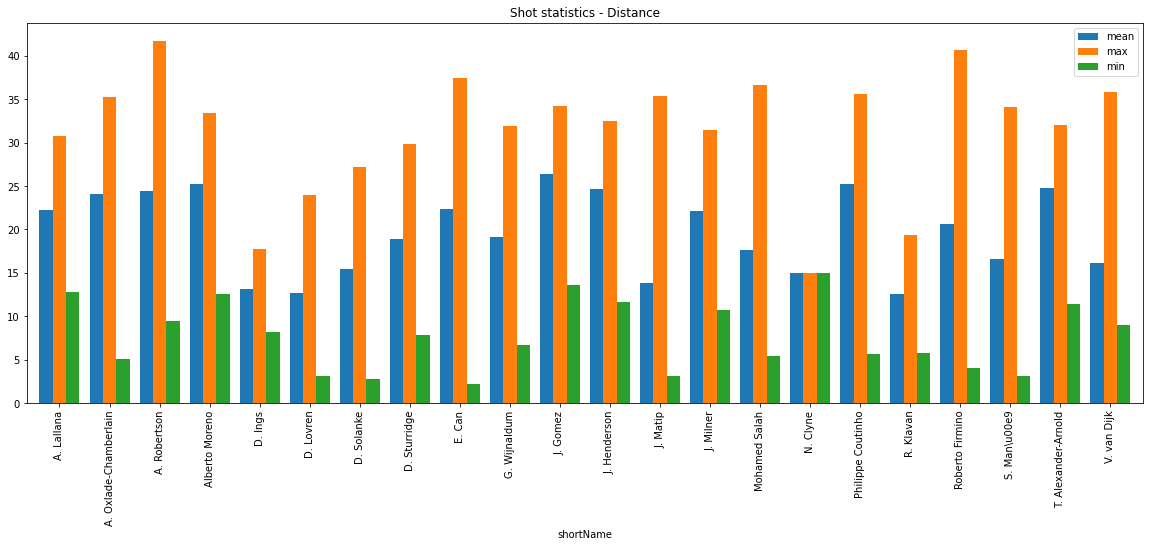

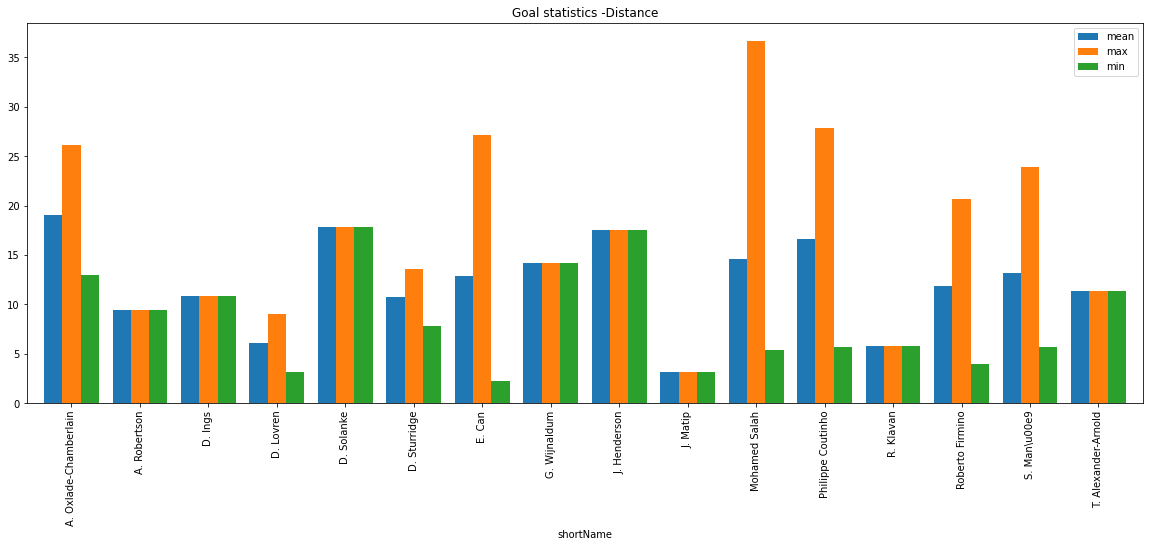

In [14]:
liverpool_shots.groupby('shortName').agg(['mean','max','min'])['distance'].plot(kind='bar',figsize=(20,7),width=0.8,title='Shot statistics - Distance')
goals.groupby('shortName').agg(['mean','max','min'])['distance'].plot(kind='bar',figsize=(20,7),width=0.8,title='Goal statistics -Distance')

### Shot and goal frequency of players

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B4BB91B00>],
      dtype=object)

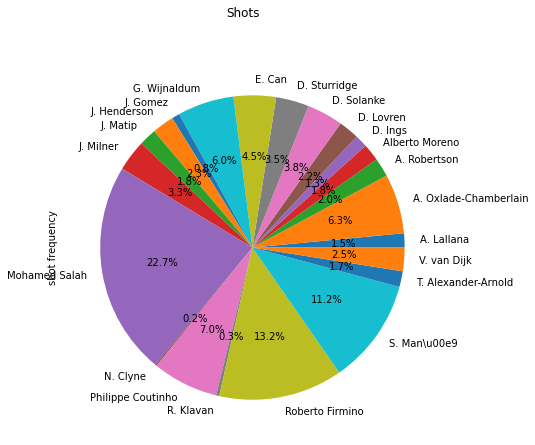

In [15]:
liverpool_shots.groupby('shortName').size().to_frame('shot frequency').plot(kind='pie',subplots=True,legend=False,figsize=(10,7),autopct='%1.1f%%',title='Shots')
# goals.groupby('shortName').size().to_frame('goal frequency').plot(kind='pie',subplots=True,legend=False,figsize=(10,7),autopct='%1.1f%%',title='Goals')

# Shot Heat Maps

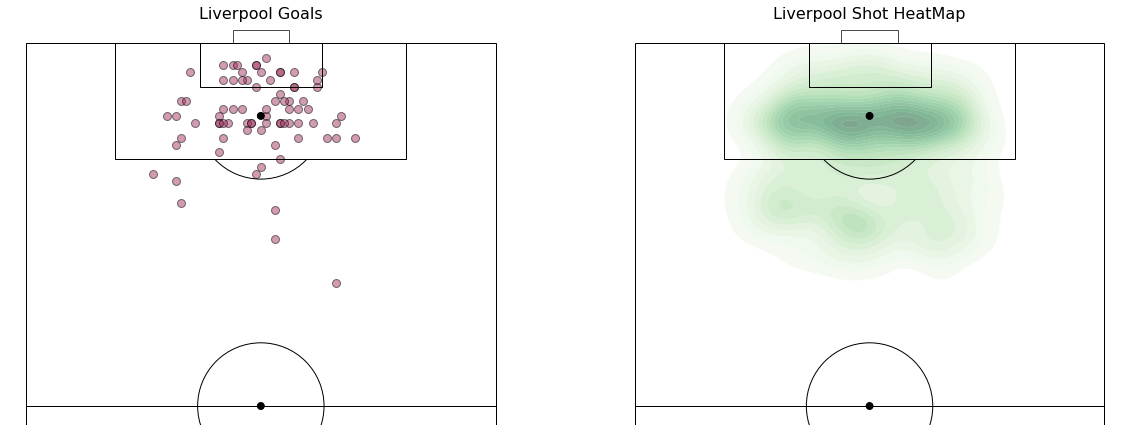

In [16]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,20))
pitch = Pitch(pitch_type='wyscout', orientation='vertical', view='half',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=5,
                  )
pitch.draw(axes[0])
pitch.draw(axes[1])

#Liverpool shozs
axes[0].set_title('Liverpool Goals',fontdict={'fontsize':16})
#pitch.plot([x[0] if x[0]>field_length/2 else field_length-x[0] for x in no_goals['loc_start']], [x[1] for x in no_goals['loc_start']], marker='o', color='None', markerfacecolor='#34afed', markersize=5, alpha=0.25, linestyle='None', ax=axes[0])

pitch.plot([direction_of_attack(x[0]) for x in goals['loc_start']], [x[1] for x in goals['loc_start']], marker='o',
           color='None', markerfacecolor='#a43967', markersize=8, alpha=0.5, linestyle='None', ax=axes[0])


#Heatmap
axes[1].set_title('Liverpool Shot HeatMap',fontdict={'fontsize':16})
pitch.kdeplot([direction_of_attack(x[0]) for x in liverpool_shots['loc_start']], 
               [x[1] for x in liverpool_shots['loc_start']], ax=axes[1], 
               shade=True, cmap="Greens",
            shade_lowest=False, n_levels=20, alpha=0.5, antialiased=True,
                cbar_kws={'orientation': 'horizontal', 'use_gridspec': True, 'fraction': 0.068, 'ticks': []}
            )


In [17]:
liverpool_playersdf = pd.DataFrame()
liverpool_playersdf['shortName'] = liverpool_shots['shortName']
liverpool_playersdf['shot_x'] = liverpool_shots['loc_start'].apply(lambda x:direction_of_attack_loc(x)[0])
liverpool_playersdf['shot_y'] = liverpool_shots['loc_start'].apply(lambda x:direction_of_attack_loc(x)[1])
liverpool_playersdf = liverpool_playersdf.merge(liverpool_shots.groupby('shortName').size().to_frame('freq').reset_index(),on='shortName')
#median value of shot location
df_shot_median = liverpool_playersdf.groupby("shortName").agg({"shot_x": "median", "shot_y": "median"}).reset_index()[['shortName','shot_x','shot_y']]
df_shot_median.rename(columns={'shot_x':'median_x','shot_y':'median_y'},inplace=True)

liverpool_playersdf = df_shot_median.merge(liverpool_playersdf[['shortName','freq']].drop_duplicates(),on='shortName',how='left')
liverpool_playersdf['freq_pct'] = round(liverpool_playersdf['freq']/liverpool_playersdf['freq'].sum()*100,2)
# liverpool_playersdf = liverpool_playersdf.merge(players_df[['shortName','wyId']],right_on='wyId',left_on='player_id')

## Shot HeatMap of different players
- Shot positions
- Shot types

In [18]:
subevents = events_org[events_org.eventName=='Shot']
# subevents = pd.concat([subevents, get_tagsdf(subevents)], axis=1)
if 'shortName' not in subevents:
    subevents = subevents.merge(players_df[['shortName','wyId']],right_on='wyId',left_on='playerId')

# accurate

The following kwargs were not used by contour: 'n_snilevels'


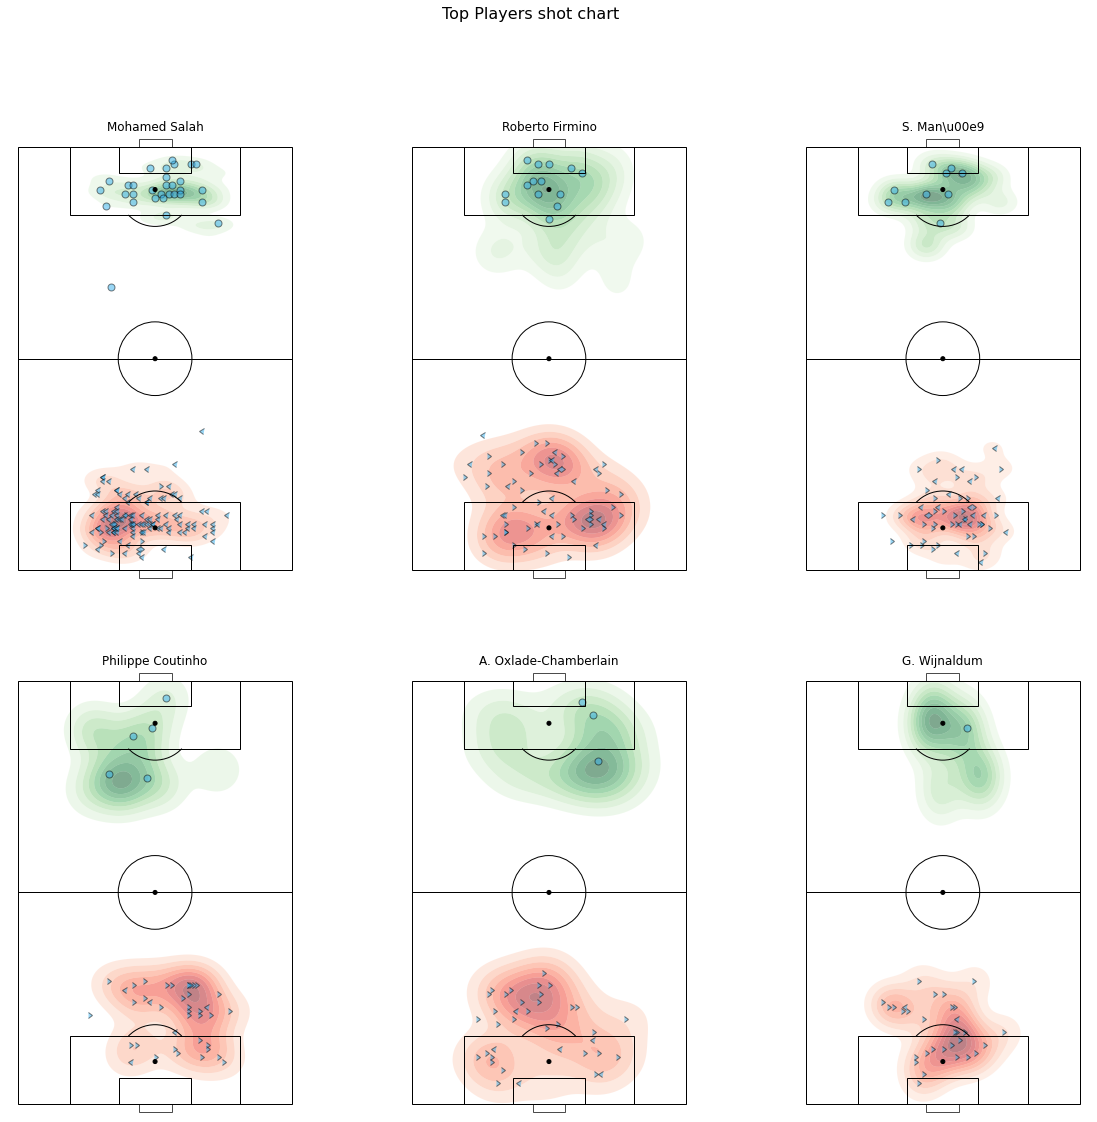

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,18))
pitch = Pitch(pitch_type='wyscout', orientation='vertical',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=5,
              view='full',tight_layout=True
)
fig.suptitle('Top Players shot chart',fontsize=16)
liverpool_shots=subevents
shortNames = liverpool_shots.groupby('shortName').size().sort_values(ascending=False).reset_index()['shortName'][0:6]
# shortNames= shortNames.replace({'S. Man\\u00e9':'Mane'})
# liverpool_shots['shortName'] = liverpool_shots.replace({'S. Man\\u00e9':'Mane'})
counter = 0
for i in range(0,2):
    for j in range(0,3):
        pitch.draw(axes[i,j])
        axes[i,j].set_title(shortNames[counter])
        
        pitch.kdeplot([x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.accurate)]['start_x']], 
                       [x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter])  & (liverpool_shots.accurate)]['start_y']],  
                       shade=True, cmap="Greens",
                        shade_lowest=False, n_snilevels=20, alpha=0.5, antialiased=True,
                        cbar_kws={'orientation': 'horizontal', 'use_gridspec': True, 'fraction': 0.068, 'ticks': []
                        },
                      ax=axes[i,j],
                    )
        pitch.kdeplot([100-x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.not_accurate)]['start_x']], 
                       [100-x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter])& (liverpool_shots.not_accurate)]['start_y']],  
                       shade=True, cmap="Reds",
                        shade_lowest=False, n_snilevels=20, alpha=0.5, antialiased=True,
                        cbar_kws={'orientation': 'horizontal', 'use_gridspec': True, 'fraction': 0.068, 'ticks': []
                        },
                      ax=axes[i,j],
                    )
        pitch.plot([x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.goal)]['start_x']],
                   [x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.goal)]['start_y']],
                   marker='o',
                   color='None', markerfacecolor='#34afed', markersize=7, alpha=0.5, linestyle='None', 
                  ax=axes[i,j]
                  )
        pitch.plot([100-x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.right_foot)]['start_x']],
                   [100-x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.right_foot)]['start_y']],
                   marker=5,
                   color='None', markerfacecolor='#34afed', markersize=6, alpha=0.5, linestyle='None', 
                  ax=axes[i,j]
                  )
        pitch.plot([100-x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.left_foot)]['start_x']],
                   [100-x for x in liverpool_shots[(liverpool_shots.shortName==shortNames[counter]) & (liverpool_shots.left_foot)]['start_y']],
                   marker=4,
                   color='None', markerfacecolor='#34afed', markersize=6, alpha=0.5, linestyle='None', 
                  ax=axes[i,j]
                  )
        counter = counter +1
#          ['#34afed' if x==0 else '#a43967' for x in liverpool_shots[liverpool_shots.shortName==shortNames[0]]['result_id']]

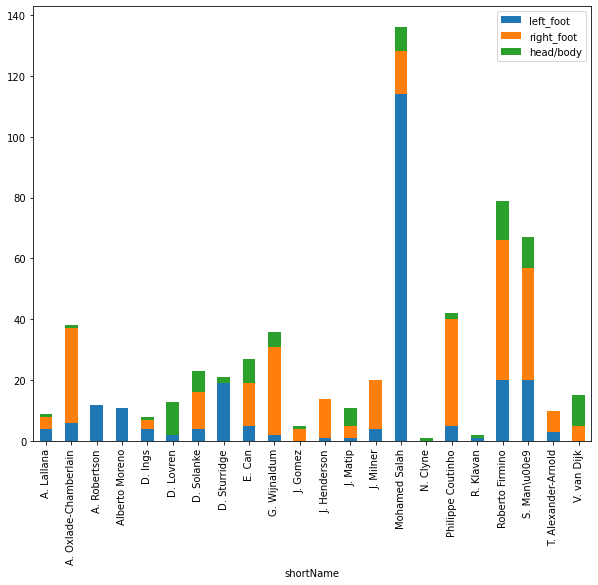

In [20]:
subevents[['left_foot','right_foot','head/body','shortName']].groupby(['shortName']).sum().plot(kind='bar',figsize=(10,8),stacked=True)
# subevents[subevents.not_accurate==True][['left_foot','right_foot','head/body','shortName']].groupby('shortName').sum().plot(kind='bar',figsize=(10,8))

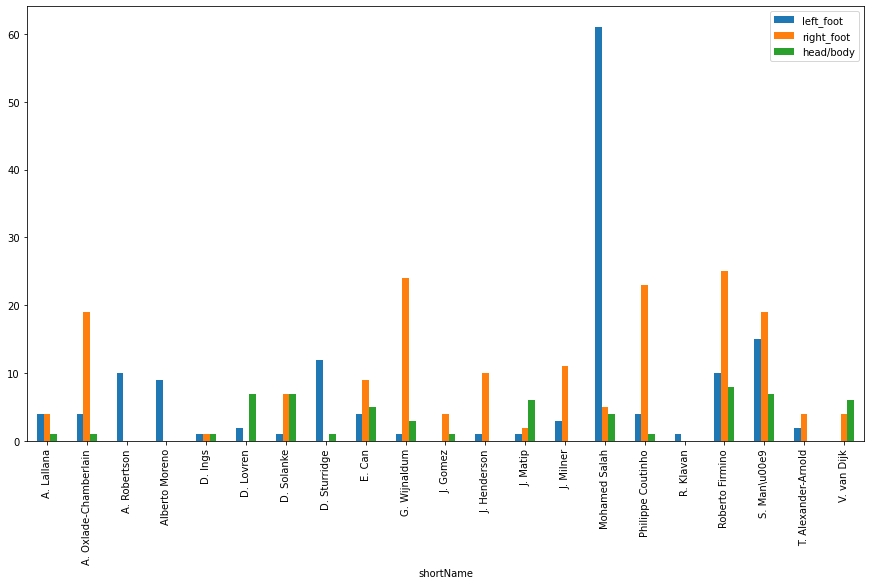

In [21]:
subevents[subevents.not_accurate==True][['left_foot','right_foot','head/body','shortName']].groupby('shortName').sum().plot(kind='bar',figsize=(15,8))

# Passing game
 Different types of passing

In [22]:
passes_df = events[events.type_id==0]# events_org[events_org.eventName=='Pass']
crosses_df = events_org[(events_org.subEventName=='Cross')]
smartpass_df = events_org[(events_org.subEventName=='Smart pass')]
through_pass_df =  events_org[(events_org.eventName=='Pass')&(events_org.through)]



## Through passes
 - Short passes
 - Long passes

27.741935483870968


Boolean Series key will be reindexed to match DataFrame index.


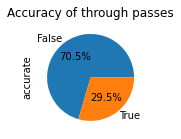

In [23]:
display(events_org[(events_org.through)].accurate.value_counts().plot(kind='pie',legend=False,figsize=(3,2),autopct='%1.1f%%',title='Accuracy of through passes'))

acc_through_passes = through_pass_df[through_pass_df.accurate]
print(len(acc_through_passes[((through_pass_df.key_pass) | (through_pass_df.assist))])/(len(acc_through_passes))*100)

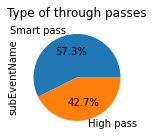

In [24]:
through_pass_df.subEventName.value_counts().plot(kind='pie',legend=False,figsize=(3,2),autopct='%1.1f%%',title='Type of through passes')

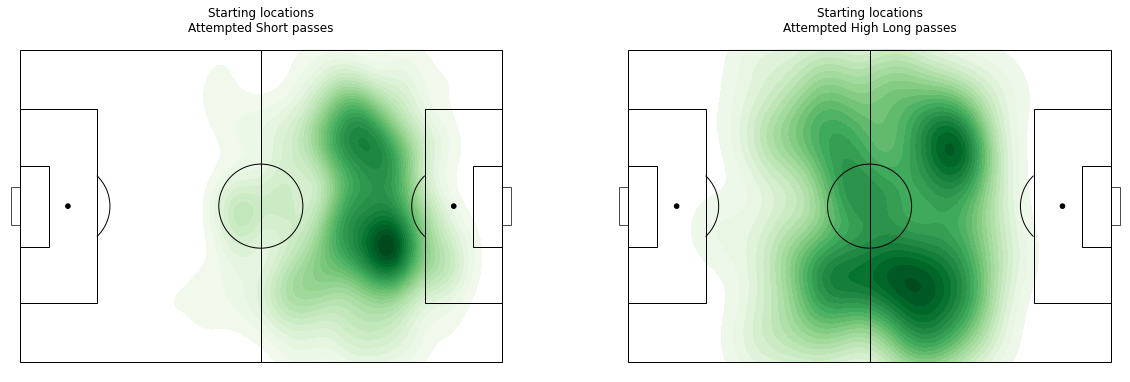

In [26]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,20))
pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=5,
                  )
pitch.draw(axes[0])
pitch.draw(axes[1])

axes[0].set_title('Starting locations\nAttempted Short passes')
pitch.kdeplot(
             through_pass_df[(through_pass_df.subEventName=='Smart pass')]['start_x'],
             through_pass_df[(through_pass_df.subEventName=='Smart pass')]['start_y'],
             shade=True, cmap="Greens",
             levels=30,
             shade_lowest=False,
             ax=axes[0],
)

#Crosses
axes[1].set_title('Starting locations\nAttempted High Long passes')
pitch.kdeplot( through_pass_df[(through_pass_df.subEventName=='High pass')]['start_x'],
             through_pass_df[(through_pass_df.subEventName=='High pass')]['start_y'],
             shade=True, cmap="Greens",
             levels=30,
             shade_lowest=False,
             ax=axes[1],
)

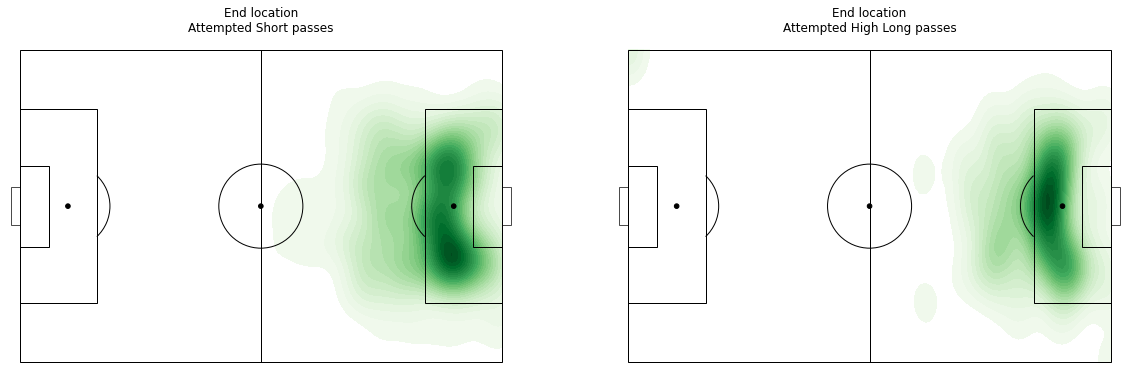

In [27]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,20))
pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=5,
                  )
pitch.draw(axes[0])
pitch.draw(axes[1])

axes[0].set_title('End location\nAttempted Short passes')
pitch.kdeplot(
             through_pass_df[(through_pass_df.subEventName=='Smart pass')]['end_x'],
             through_pass_df[(through_pass_df.subEventName=='Smart pass')]['end_y'],
             shade=True, cmap="Greens",
             levels=30,
             shade_lowest=False,
             ax=axes[0],
)

#Crosses
axes[1].set_title('End location\nAttempted High Long passes')
pitch.kdeplot( through_pass_df[(through_pass_df.subEventName=='High pass')]['end_x'],
             through_pass_df[(through_pass_df.subEventName=='High pass')]['end_y'],
             shade=True, cmap="Greens",
             levels=30,
             shade_lowest=False,
             ax=axes[1],
)

### Created scoring opportunities from through passes
 - Passes that lead to scoring opportunity

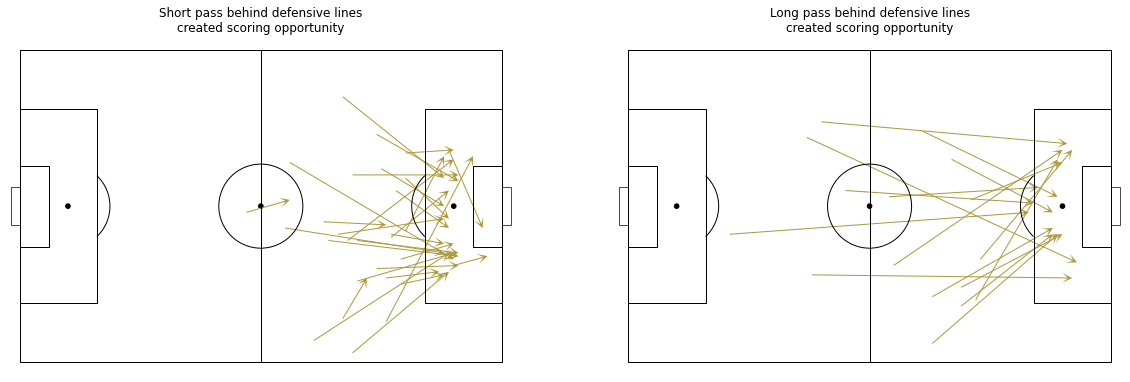

In [28]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,20))
pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=5,
                  )
pitch.draw(axes[0])
pitch.draw(axes[1])
axes[0].set_title('Short pass behind defensive lines\ncreated scoring opportunity')
pitch.quiver([x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))& (through_pass_df.subEventName=='Smart pass')]['start_x']],
            [x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))& (through_pass_df.subEventName=='Smart pass')]['start_y']],
            [x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))& (through_pass_df.subEventName=='Smart pass')]['end_x']],
            [x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))&(through_pass_df.subEventName=='Smart pass')]['end_y']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = '#ad993c', label = 'dribbles',
             linestyle ='-',
            ax=axes[0],
            
)
axes[1].set_title('Long pass behind defensive lines\ncreated scoring opportunity')
pitch.quiver([x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))& (through_pass_df.subEventName=='High pass')]['start_x']],
            [x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))& (through_pass_df.subEventName=='High pass')]['start_y']],
            [x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))& (through_pass_df.subEventName=='High pass')]['end_x']],
            [x for x in through_pass_df[((through_pass_df.key_pass | through_pass_df.assist))& (through_pass_df.subEventName=='High pass')]['end_y']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = '#ad993c', label = 'dribbles',
             linestyle ='-',
            ax=axes[1]
)


- some stats for through passes

In [29]:
print('Through passes attempted')
print(through_pass_df.subEventName.value_counts()/len(list(set(through_pass_df.matchId))))
print(through_pass_df[through_pass_df.accurate].subEventName.value_counts()/len(list(set(through_pass_df.matchId))))
print(through_pass_df[(through_pass_df.accurate) & (through_pass_df.key_pass | through_pass_df.assist)].subEventName.value_counts()/len(list(set(through_pass_df.matchId))))

Through passes attempted
Smart pass    7.921053
High pass     5.894737
Name: subEventName, dtype: float64
Smart pass    2.184211
High pass     1.894737
Name: subEventName, dtype: float64
Smart pass    0.710526
High pass     0.421053
Name: subEventName, dtype: float64


### Players with most passing attempts
 - only through passes

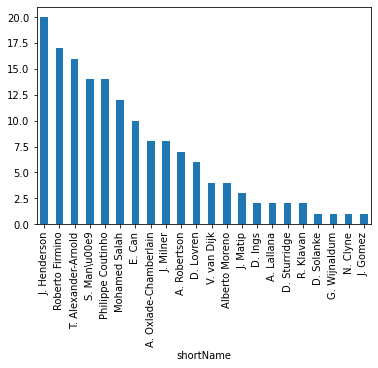

In [30]:
#kdo je komu podall
if 'shortName' not in through_pass_df:
    through_pass_df = through_pass_df.merge(players_df[['shortName','wyId']],right_on='wyId',left_on='playerId')

through_pass_df[((through_pass_df.accurate))].groupby('shortName').size().sort_values(ascending=False).plot(kind='bar') 
# through_pass_df[(through_pass_df.subEventName=='Smart pass')].groupby('shortName').size()
#through_pass_df[(through_pass_df.subEventName=='High pass')].groupby('shortName').size().sort_values(ascending=False).plot(kind='bar')

## Visualize passing network

In [31]:
network_long_pass = list()#(through_pass_df.key_pass)&
for idx, row in through_pass_df[((through_pass_df.accurate))& (through_pass_df.subEventName=='High pass')].iterrows():
    id_ = events_org[events_org.id==row['id']].index
    network_long_pass.append({
        'pass_from':row.shortName,
        'pass_to':events_org.loc[id_+1].iloc[0].playerId,
        'start_x':row['start_x'],
        'start_y':row['start_y'],
        'end_loc_x':row['end_x'],
        'end_loc_y':row['end_y'],
        'accurate':row['accurate'],
    })

network_smart_pass = list()
for idx, row in through_pass_df[((through_pass_df.accurate))& (through_pass_df.subEventName=='Smart pass')].iterrows():
    id_ = events_org[events_org.id==row['id']].index
    network_smart_pass.append({
        'pass_from':row.shortName,
        'pass_to':events_org.loc[id_+1].iloc[0].playerId,
        'start_x':row['start_x'],
        'start_y':row['start_y'],
        'end_loc_x':row['end_x'],
        'end_loc_y':row['end_y'],
        'accurate':row['accurate'],
    })

df_longpass_network= pd.DataFrame(network_long_pass)   
df_smartpass_network= pd.DataFrame(network_smart_pass)  

df_longpass_network = df_longpass_network.merge(players_df[['shortName','wyId']], left_on='pass_to',right_on='wyId')
df_smartpass_network = df_smartpass_network.merge(players_df[['shortName','wyId']],left_on='pass_to',right_on='wyId')

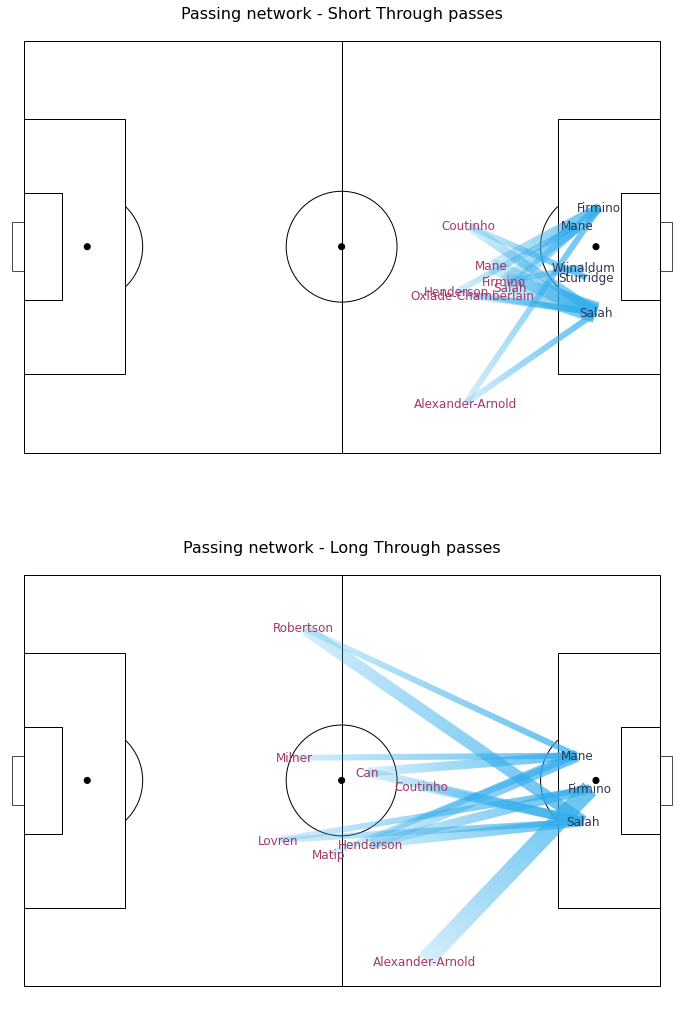

In [32]:
def rename_player(name):
    return name.replace('Man\\u00e9','Mane')

annotate_font_size = 12

df_smartpass_network_median_from = df_smartpass_network.groupby("pass_from").agg({"start_x": "median", "start_y": "median"}).reset_index()[['pass_from','start_x','start_y']]
df_smartpass_network_median_to = df_smartpass_network.groupby("shortName").agg({"end_loc_x": "median", "end_loc_y": "median"}).reset_index()[['shortName','end_loc_x','end_loc_y']]

df_longpass_network_median_from = df_longpass_network.groupby("pass_from").agg({"start_x": "median", "start_y": "median"}).reset_index()[['pass_from','start_x','start_y']]
df_longpass_network_median_to = df_longpass_network.groupby("shortName").agg({"end_loc_x": "median", "end_loc_y": "median"}).reset_index()[['shortName','end_loc_x','end_loc_y']]



fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,18))
axes[0].set_title('Passing network - Short Through passes',fontdict={'fontsize':16})

pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=1,
              view='full'
                  )
pitch.draw(axes[0])
pitch.draw(axes[1])

#Smart passes
smart_pass_size = df_smartpass_network.groupby(['pass_from','shortName']).size().to_frame('size').reset_index()
smart_pass_size = smart_pass_size[smart_pass_size['size']>1]

for idx,row in df_smartpass_network_median_from.iterrows():
    if row['pass_from'] in smart_pass_size['pass_from'].values:
        name = row['pass_from'].split(' ')[-1] 
        pitch.annotate(rename_player(name), (row['start_x'],row['start_y']), color = '#a43967',
                       fontsize = annotate_font_size, ha = 'center', va = 'center', ax = axes[0])
    
for idx,row in df_smartpass_network_median_to.iterrows():
    if row['shortName'] in smart_pass_size['shortName'].values:
        name = row['shortName'].split(' ')[-1] 
        pitch.annotate(rename_player(name), (row['end_loc_x'],row['end_loc_y']), color = '#2f3653',
                       fontsize = annotate_font_size, ha = 'center', va = 'center', ax = axes[0])
        
#         axes[0].annotate(name, xy=(row['end_loc_x'],row['end_loc_y']), ha="center", va="center", zorder=8,
#                     fontsize=12, color='blue', weight='bold',
#                     path_effects=[pe.withStroke(linewidth=2, foreground='grey')])

for idx,row in smart_pass_size.iterrows():
    
    pass_from =df_smartpass_network_median_from[df_smartpass_network_median_from.pass_from==row.pass_from]
    pass_to = df_smartpass_network_median_to[df_smartpass_network_median_to.shortName==row.shortName]
    pitch.lines(pass_from['start_x'],pass_from['start_y'],
                pass_to['end_loc_x'],pass_to['end_loc_y'],
                 lw=row['size']*3,
                transparent=True,comet=False,zorder=3,
                ax=axes[0])
#     num_passes = row["size"]
#     pass_value = 10
#     norm = Normalize(vmin=0, vmax=smart_pass_size['size'].max())
#     edge_cmap =   cm.get_cmap('Reds')
#     edge_color = edge_cmap(norm(pass_value))
#     ax.plot(pass_from['start_x'],pass_from['start_y'], 
#             pass_to['end_loc_x'],pass_to['end_loc_y'],
#                     'w-', linestyle='-', alpha=1, lw=num_passes, zorder=7, color=edge_color)
    
    
#     axes[0].plot(pass_from['start_x'],pass_from['start_y'], '.', color='red', markersize=20, zorder=6)
#     axes[0].plot(pass_from['start_x'],pass_from['start_y'], '.', color='grey', markersize=10, zorder=7)
    
    
    
axes[1].set_title('Passing network - Long Through passes',fontdict={'fontsize':16})
#Long passes
long_pass_size = df_longpass_network.groupby(['pass_from','shortName']).size().to_frame('size').reset_index()
long_pass_size = long_pass_size[long_pass_size['size']>1]

for idx,row in df_longpass_network_median_from.iterrows():
    if row['pass_from'] in long_pass_size['pass_from'].values:
        pitch.annotate(row['pass_from'].split(' ')[-1], (row['start_x'],row['start_y']), color = '#a43967',
                       fontsize = annotate_font_size, ha = 'center', va = 'center', ax = axes[1])
    
for idx,row in df_longpass_network_median_to.iterrows():
    if row['shortName'] in long_pass_size['shortName'].values:
        name = row['shortName'].split(' ')[-1]       
        axes[1].annotate(rename_player(name), (row['end_loc_x'],row['end_loc_y']), color = '#2f3653',
                       fontsize = annotate_font_size, ha = 'center', va = 'center')

#Pass network
for idx,row in long_pass_size.iterrows():
    
    pass_from =df_longpass_network_median_from[df_longpass_network_median_from.pass_from==row.pass_from]
    pass_to = df_longpass_network_median_to[df_longpass_network_median_to.shortName==row.shortName]
    pitch.lines(pass_from['start_x'],pass_from['start_y'],
                pass_to['end_loc_x'],pass_to['end_loc_y'],
                lw=row['size']*3,
                transparent=True,comet=False,zorder=3,
                ax=axes[1])

# Tracking data
 - Reading @Lastrow tracking data
 - Some processing

In [33]:
extra_data = pd.read_csv('C:\FoTProjects\datasciencesoccer\liverpool_analitics/Liverpool_2019_event_data.csv')#[['play','isLongPass','isSmartPass','isThroughPass','GoalType']]

def scale_to_visual2(shot_location_start, scale=(100,100), 
                    field_dim=(106, 68), 
                    to_single_direction=False, 
                    flip_y=False,
                    flip_x=False,
                    orientation='horizontal'):
    """
    scales to fit visual
    """
    x_scale = scale[0] / field_dim[0]
    y_scale = scale[1] / field_dim[1]

    x = np.round(shot_location_start[0] * x_scale)
    y = np.round(shot_location_start[1] * y_scale)
    
    if to_single_direction and x<scale[0]/2:
        x = scale[0] - x
        # y=  scale[1] - y
        
    if flip_y:
        y = scale[1] - y
    if flip_x:
        x = scale[0] - x
        
    if orientation == 'horizontal':
        return [x, y]
    return [y, x]

def get_possession_df(df):
    #get a DataFrame for Ball position
    dfBall = df.reset_index()[df.reset_index().player==0].set_index('frame')[['x', 'y']]

    #temporary DataFrame with all player's position relative to the ball
    dfTemp = df.reset_index().set_index('frame').join(dfBall, rsuffix='_ball')
    dfTemp = dfTemp[dfTemp.player!=0]
    dfTemp['dif_x'] = dfTemp['x'].sub(dfTemp['x_ball'])
    dfTemp['dif_y'] = (dfTemp['y'] - dfTemp['y_ball'])

    #DataFrame with all the frames where a player touches or has close control of the ball.
    dfPossession = dfTemp[((dfTemp[['dif_x', 'dif_y']]==0).sum(axis=1))==2].reset_index()
    dfPossession.player_num = dfPossession.player_num.astype('Int64')
    

    
    return dfPossession


def get_passes_df(dfPossession):
    # determining the start end enf of each possession block
    poss_start = dfPossession[dfPossession['player'] != dfPossession.shift(1)['player']]
    poss_end = dfPossession[dfPossession['player'] != dfPossession.shift(-1)['player']]

    # relevant columns to keep in the final DataFrame
    columns = ['team', 'x', 'y', 'frame', 'player_num']

    # list of all changes in possession
    dfPasses = pd.concat([poss_end.reset_index()[columns].rename(lambda x: 'from_{}'.format(x), axis='columns'),
                          poss_start.iloc[1:].reset_index()[columns].rename(lambda x: 'to_{}'.format(x), axis='columns')
                          ], axis='columns')

    # keep all changes in possession from players of the same team
    dfPasses = dfPasses[dfPasses['from_team'] == dfPasses['to_team']]
    return dfPasses

def transform_coordinates(dfPasses):
    dfPasses['from_loc'] = [scale_to_visual2((x[0],x[1]), field_dim=(100, 100), orientation='horizontal', flip_x=x[2] < 50, flip_y=x[2] > 50)
              for x in dfPasses[['from_x','from_y','attack_direction']].values]
   
    dfPasses['to_loc'] = [scale_to_visual2((x[0],x[1]), field_dim=(100, 100), orientation='horizontal', flip_x=x[2] < 50, flip_y=x[2] > 50)
                          for x in dfPasses[['to_x','to_y','attack_direction']].values]
    return dfPasses


def is_through_pass(df_pass, df_defense):
    
    return np.count_nonzero([True for x in freeze_frame_from[freeze_frame_from.team=='defense']['loc'] if x[0]>row['to_x']] )<2 #keeper is last man
    
def find_long_pass(dfPasses, df):
    
    dfPasses['isLongPass'] = [True if (abs(x[0][0]-x[1][0]) > 20 and (x[1][0]>50)) else False for x in dfPasses[['from_loc','to_loc']].values]

    

 - Create Event Data From Tracking data

In [34]:
data = pd.read_csv('C:/FoTProjects/Last-Row/datasets/positional_data/liverpool_2019.csv',
                       index_col=('play', 'frame'))

frames = dict()
custom_event_data = list()
#Read the data and find freeze frame
for play in data.index.get_level_values('play').unique():
    df = data.loc[play]
    custom_event = get_passes_df(get_possession_df(df))
    custom_event = custom_event.merge(extra_data[['isLongPass','isSmartPass','isThroughPass','GoalType','from_frame','to_frame','isCross','isOnWinPass','isCutback']],on=['from_frame','to_frame'])
    
    custom_event['play'] = play
    
    
    df = df.reset_index()
    dfb = df[df.player == 0] #ball
    dfp = df[df.player != 0] #players
    dfb = dfb[['frame', 'x', 'y']].rename(columns={'x': 'bx', 'y': 'by'})
    m = dfb.merge(dfp[['frame', 'player', 'x', 'y']], on='frame')
    find_frame = m[(m.bx == m.x) & (m.by == m.y)]['frame'].max() #find last position of the ball before shot

    frame = df.iloc[find_frame] #.set_index('player')
    frame['loc'] = scale_to_visual(frame[['x', 'y']], field_dim=(100, 100), orientation='horizontal')
    frame['play'] = play
    frame['freeze_shot'] = df[df.frame == find_frame][['team', 'x', 'y','player_num']]
    
    frames[play] = frame
    
    custom_event['attack_direction'] = frame['freeze_shot'][~frame['freeze_shot'].isin(['attack', 'defense'])].iloc[0]['x'] #get attack direction of team
    custom_event =transform_coordinates(custom_event)
    
    find_long_pass(custom_event,df) #
    
    custom_event = custom_event[custom_event.from_team == 'attack'] #keep only liverpool events
    custom_event_data.append(custom_event)

custom_event_data_df = pd.concat(custom_event_data)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Pass map from tracking data

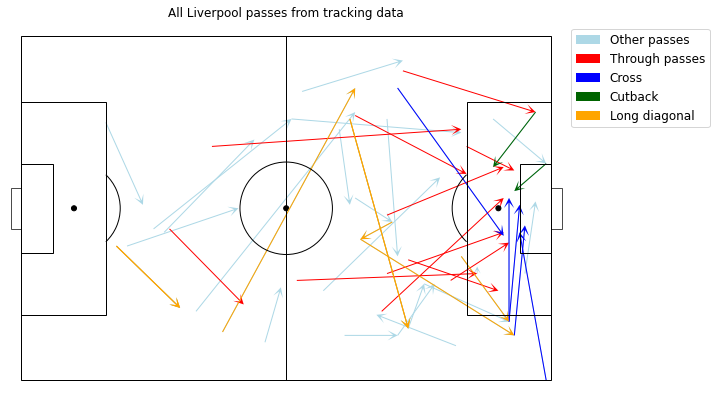

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=2,
                  )
pitch.draw(axes)
axes.set_title('All Liverpool passes from tracking data')

pitch.quiver([x[0] for x in custom_event_data_df[~custom_event_data_df.isThroughPass]['from_loc']],
            [x[1] for x in custom_event_data_df[~custom_event_data_df.isThroughPass]['from_loc']],
            [x[0] for x in custom_event_data_df[~custom_event_data_df.isThroughPass]['to_loc']],
            [x[1] for x in custom_event_data_df[~custom_event_data_df.isThroughPass]['to_loc']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = 'lightblue', label = 'Other passes',
             linestyle ='-',
            ax=axes,
            )


pitch.quiver([x[0] for x in custom_event_data_df[custom_event_data_df.isThroughPass]['from_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isThroughPass]['from_loc']],
            [x[0] for x in custom_event_data_df[custom_event_data_df.isThroughPass]['to_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isThroughPass]['to_loc']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = 'red', label = 'Through passes',
             linestyle ='-',
            ax=axes,
            )


pitch.quiver([x[0] for x in custom_event_data_df[custom_event_data_df.isCross]['from_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isCross]['from_loc']],
            [x[0] for x in custom_event_data_df[custom_event_data_df.isCross]['to_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isCross]['to_loc']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = 'blue', label = 'Cross',
             linestyle ='-',
            ax=axes,
            )

pitch.quiver([x[0] for x in custom_event_data_df[custom_event_data_df.isCutback]['from_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isCutback]['from_loc']],
            [x[0] for x in custom_event_data_df[custom_event_data_df.isCutback]['to_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isCutback]['to_loc']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = 'darkgreen', label = 'Cutback',
             linestyle ='-',
            ax=axes,
            )

pitch.quiver([x[0] for x in custom_event_data_df[custom_event_data_df.isOnWinPass]['from_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isOnWinPass]['from_loc']],
            [x[0] for x in custom_event_data_df[custom_event_data_df.isOnWinPass]['to_loc']],
            [x[1] for x in custom_event_data_df[custom_event_data_df.isOnWinPass]['to_loc']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = 'orange', label = 'Long diagonal',
             linestyle ='-',
            ax=axes,
            )


axes.legend(fontsize = 'large',loc='upper left',bbox_to_anchor=(1, 1))


In [1]:
# df_passing_network = custom_event_data_df.copy() # extra_data[extra_data.from_team=='attack'][['from_player_num','to_player_num','from_x','from_y','to_x','from_x','isThroughPass','isLongPass']]
# df_means = df_passing_network.groupby('from_player_num').mean()[['from_x','from_y','to_x','to_y']].reset_index().rename(
#     columns={'from_x':'mean_from_x','from_y':'mean_from_y','to_x':'mean_to_x','to_y':'mean_to_y'}
# )
# # fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
# # for idx,row in df_means.iterrows():
# #     axes.annotate(row['from_player_num'], xy=(row['mean_from_x'],row['mean_from_y']), ha="center", va="center", 
# #                   zorder=1,
# #                     fontsize=12, color='blue', weight='bold',
# #                     path_effects=[pe.withStroke(linewidth=2, foreground='grey')])
    
# # df_passing_network.groupby('from_player_num').mean()['from_x'].reset_index()
# # max_player_count = player_pass_count.num_passes.max() if max_player_count is None else max_player_count
# # max_player_value = player_pass_value.pass_value.max() if max_player_value is None else max_player_value
# # max_pair_count = pair_pass_count.num_passes.max() if max_pair_count is None else max_pair_count
# # max_pair_value = pair_pass_value.pass_value.max() if max_pair_value is None else max_pair_value

NameError: name 'custom_event_data_df' is not defined

# Pitch control

In [35]:
from Pitchcontrol_lastrow import default_model_params, generate_pitch_control_for_frame
import pandas as pd
import numpy as np
import sys, os
import scipy.signal as signal
from matplotlib import pyplot as plt

- import preprocessed data

In [37]:
data_test = pd.read_hdf('lastrow_pitchcontrol_data.hdf', key='lr')
# play = 'Liverpool [2] - 1 Newcastle'
# play_df = data_test[data_test['play'] == play]
# tracking_attack = play_df[play_df['team'] == 'attack']
# tracking_defense = play_df[play_df['team'] == 'defense']
# frame = 10

# params = default_model_params()
# PPCF, xgrid, ygrid = generate_pitch_control_for_frame(frame, tracking_attack, tracking_defense, params,
#                                                          field_dimen=(106., 68.,), n_grid_cells_x=25)
# # footyviz.plot_pitchcontrol_for_frame(frame, tracking_attack, tracking_defense, PPCF, xgrid, ygrid, alpha=0.7,
# #                                      include_player_velocities=True, field_dimen=(106.0, 68))

In [38]:
def plot_pitch(ax, field_dimen=(106.0, 68.0), field_color='green', linewidth=2, markersize=20):
    """ plot_pitch

    Plots a soccer pitch. All distance units converted to meters.

    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20

    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
#     fig, ax = plt.subplots(figsize=(12, 8))  # create a figure
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color == 'green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke'  # line color
        pc = 'w'  # 'spot' colors
    elif field_color == 'white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3, 3)  # include a border arround of the field of width 3m
    meters_per_yard = 0.9144  # unit conversion from yards to meters
    half_pitch_length = field_dimen[0] / 2.  # length of half pitch
    half_pitch_width = field_dimen[1] / 2.  # width of half pitch
    signs = [-1, 1]
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8 * meters_per_yard
    box_width = 20 * meters_per_yard
    box_length = 6 * meters_per_yard
    area_width = 44 * meters_per_yard
    area_length = 18 * meters_per_yard
    penalty_spot = 12 * meters_per_yard
    corner_radius = 1 * meters_per_yard
    D_length = 8 * meters_per_yard
    D_radius = 10 * meters_per_yard
    D_pos = 12 * meters_per_yard
    centre_circle_radius = 10 * meters_per_yard
    # plot half way line # center circle
    ax.plot([0, 0], [-half_pitch_width, half_pitch_width], lc, linewidth=linewidth)
    ax.scatter(0.0, 0.0, marker='o', facecolor=lc, linewidth=0, s=markersize)
    y = np.linspace(-1, 1, 50) * centre_circle_radius
    x = np.sqrt(centre_circle_radius ** 2 - y ** 2)
    ax.plot(x, y, lc, linewidth=linewidth)
    ax.plot(-x, y, lc, linewidth=linewidth)
    for s in signs:  # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length, half_pitch_length], [s * half_pitch_width, s * half_pitch_width], lc,
                linewidth=linewidth)
        ax.plot([s * half_pitch_length, s * half_pitch_length], [-half_pitch_width, half_pitch_width], lc,
                linewidth=linewidth)
        # goal posts & line
        ax.plot([s * half_pitch_length, s * half_pitch_length], [-goal_line_width / 2., goal_line_width / 2.], pc + 's',
                markersize=6 * markersize / 20., linewidth=linewidth)
        # 6 yard box
        ax.plot([s * half_pitch_length, s * half_pitch_length - s * box_length], [box_width / 2., box_width / 2.], lc,
                linewidth=linewidth)
        ax.plot([s * half_pitch_length, s * half_pitch_length - s * box_length], [-box_width / 2., -box_width / 2.], lc,
                linewidth=linewidth)
        ax.plot([s * half_pitch_length - s * box_length, s * half_pitch_length - s * box_length],
                [-box_width / 2., box_width / 2.], lc, linewidth=linewidth)
        # penalty area
        ax.plot([s * half_pitch_length, s * half_pitch_length - s * area_length], [area_width / 2., area_width / 2.],
                lc, linewidth=linewidth)
        ax.plot([s * half_pitch_length, s * half_pitch_length - s * area_length], [-area_width / 2., -area_width / 2.],
                lc, linewidth=linewidth)
        ax.plot([s * half_pitch_length - s * area_length, s * half_pitch_length - s * area_length],
                [-area_width / 2., area_width / 2.], lc, linewidth=linewidth)
        # penalty spot
        ax.scatter(s * half_pitch_length - s * penalty_spot, 0.0, marker='o', facecolor=lc, linewidth=0, s=markersize)
        # corner flags
        y = np.linspace(0, 1, 50) * corner_radius
        x = np.sqrt(corner_radius ** 2 - y ** 2)
        ax.plot(s * half_pitch_length - s * x, -half_pitch_width + y, lc, linewidth=linewidth)
        ax.plot(s * half_pitch_length - s * x, half_pitch_width - y, lc, linewidth=linewidth)
        # draw the D
        y = np.linspace(-1, 1, 50) * D_length  # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius ** 2 - y ** 2) + D_pos
        ax.plot(s * half_pitch_length - s * x, y, lc, linewidth=linewidth)

    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0] / 2. + border_dimen[0]
    ymax = field_dimen[1] / 2. + border_dimen[1]
    ax.set_xlim([-xmax, xmax])
    ax.set_ylim([-ymax, ymax])
    ax.set_axisbelow(True)
    return fig, ax

def plot_frame(attackteam, defenseteam, figax=None, team_colors=('r', 'b'), field_dimen=(106.0, 68.0),
               include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7):
    """ plot_frame(attackteam, defenseteam)

    Plots a frame of last Row tracking data (player positions and the ball) on a football pitch. All distances should be in meters.

    Parameters
    -----------
        attackteam: row (i.e. instant) of the home team tracking data frame
        defenseteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)

    Returrns
    -----------
       fig,ax : figure and axis objects (so that other data can be plotted onto the pitch)

    """
    if figax is None:  # create new pitch
        fig, ax = plot_pitch(field_dimen=field_dimen)
    else:  # overlay on a previously generated pitch
        fig, ax = figax  # unpack tuple

    # plot home & away teams in order
    for team, color in zip([attackteam, defenseteam], team_colors):
        x_pos = np.array(team['x_m'], dtype=float)  # column header for player x positions
        y_pos = np.array(team['y_m'], dtype=float)  # column header for player y positions
        ax.plot(x_pos, y_pos, color + 'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha)  # plot player positions
        if include_player_velocities:
            vx_val = np.array(team['vx_m'], dtype=float)  # column header for player x positions
            vy_val = np.array(team['vy_m'], dtype=float)  # column header for player y positions
            ax.quiver(x_pos, y_pos, vx_val, vy_val, color=color, scale_units='inches', scale=10., width=0.0025,
                      headlength=4, headwidth=4, alpha=PlayerAlpha)
    # plot ball
    ax.plot(list(attackteam['ball_x_m'])[0], list(attackteam['ball_y_m'])[0], 'ko', MarkerSize=6, alpha=1.0,
            LineWidth=0)
    return fig, ax

# Pitch control
- customizing position of players to see the impack on pitch control

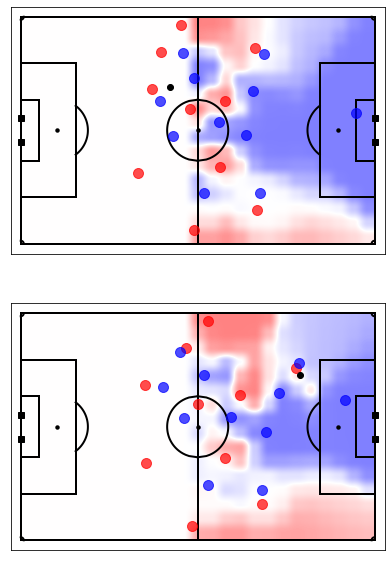

In [55]:
custom_event_data_df = pd.read_csv('C:/FoTProjects\datasciencesoccer/custom_event_data_df_temp.csv')
param1 = default_model_params()#defense
param2 = default_model_params()#offense
# params2['max_player_speed'] = 6 #change speed for liverpool
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
counter = 0
for id_, row in custom_event_data_df[(custom_event_data_df.isThroughPass)][:].iterrows():
    if 'Bayern' not in row['play']:
            continue
    play_df = data_test[data_test['play'] == row['play']]
    tracking_attack = play_df[play_df['team'] == 'attack']
    tracking_defense = play_df[play_df['team'] == 'defense']
    
    for add_to_frame in [5,50]: #Custom frames
        frame = row['from_frame'] + add_to_frame
        
        PPCF, xgrid, ygrid = generate_pitch_control_for_frame(frame,row['attack_direction'], tracking_attack, tracking_defense, param1, param2,
                                                                 field_dimen=(106., 68.,), n_grid_cells_x=25)
        # plot pitch control surface
        plot_pitch(ax= axes[counter],field_color='white')
        plot_frame(tracking_attack[tracking_attack['frame'] == frame], tracking_defense[tracking_defense['frame'] == frame],
                   figax=(fig, axes[counter]), PlayerAlpha=0.7, include_player_velocities=False)

        cmap = 'bwr'
        axes[counter].imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),
                  interpolation='hanning', vmin=0.0, vmax=1.0, cmap=cmap, alpha=0.5)
        counter = counter +1
        

# Visualize begin and and of through passes

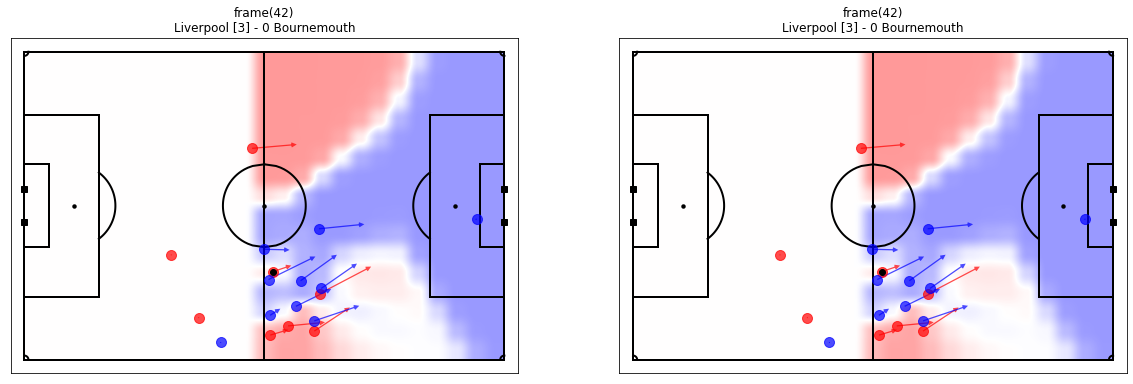

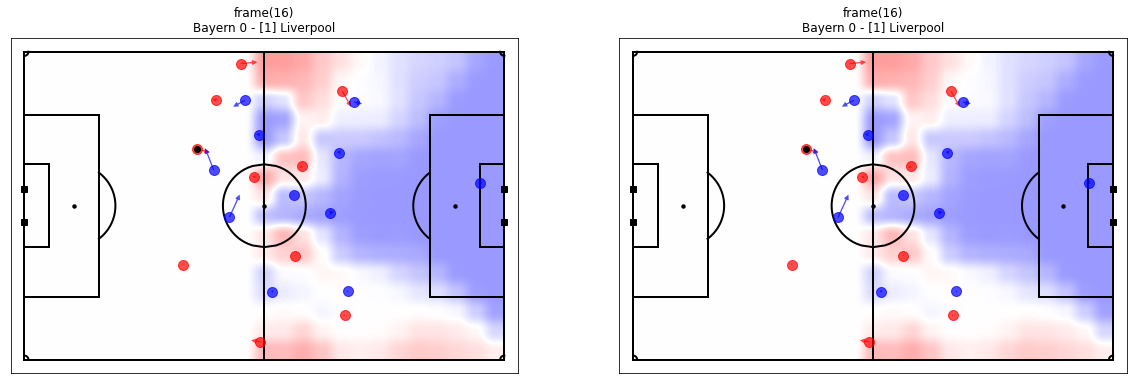

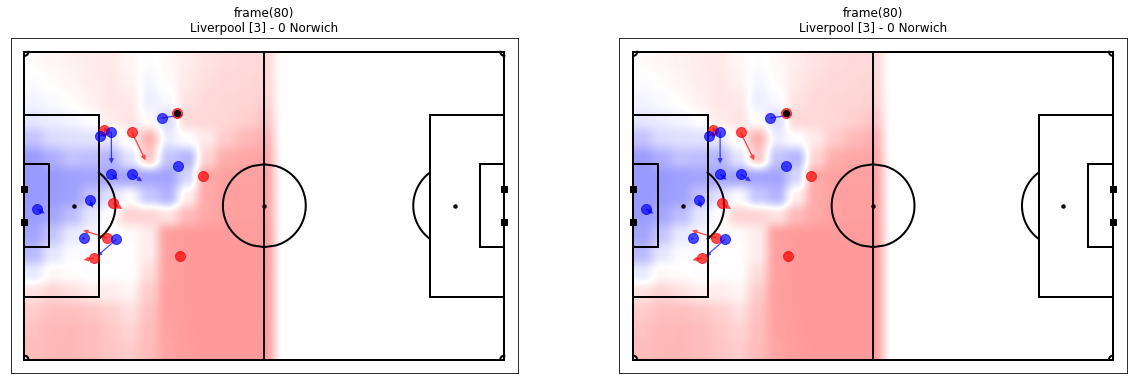

In [107]:
param1 = default_model_params()#defense
param2 = default_model_params()#offense
param1['max_player_speed']=5
params2['max_player_speed'] = 9 #change speed for liverpool
for id, row in custom_event_data_df[(custom_event_data_df.isThroughPass)&(custom_event_data_df.isLongPass)][0:3].iterrows():
    
   
    play_df = data_test[data_test['play'] == row['play']]
    tracking_attack = play_df[play_df['team'] == 'attack']
    tracking_defense = play_df[play_df['team'] == 'defense']
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    counter = 0
    frame = row['from_frame']
#     for frame in [row['from_frame'],row['to_frame']]:
    for params in [[param1,param1],[param1,param2]]:#[row['from_frame'],row['to_frame']]:
        
        axes[counter].set_title('frame({})\n{}'.format(frame,row['play']))
        PPCF, xgrid, ygrid = generate_pitch_control_for_frame(frame,row['attack_direction'], tracking_attack, tracking_defense, params[0], params[1],
                                                                 field_dimen=(106., 68.,), n_grid_cells_x=25)
        # plot pitch control surface
        plot_pitch(ax= axes[counter],field_color='white')
        plot_frame(tracking_attack[tracking_attack['frame'] == frame], tracking_defense[tracking_defense['frame'] == frame],
                   figax=(fig, axes[counter]), include_player_velocities=True)

        cmap = 'bwr'
        axes[counter].imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),
                  interpolation='hanning', vmin=0.0, vmax=1.0, cmap=cmap, alpha=0.4)
        counter = counter +1


## Visualization of through passes from tracking data

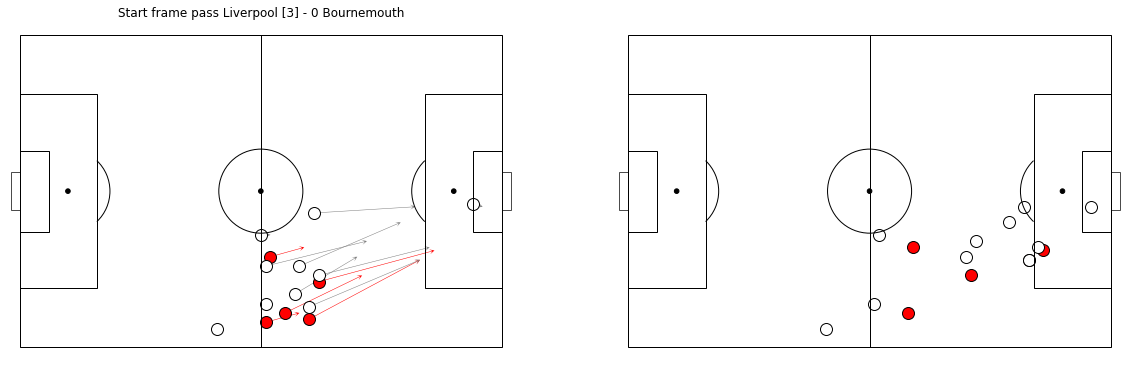

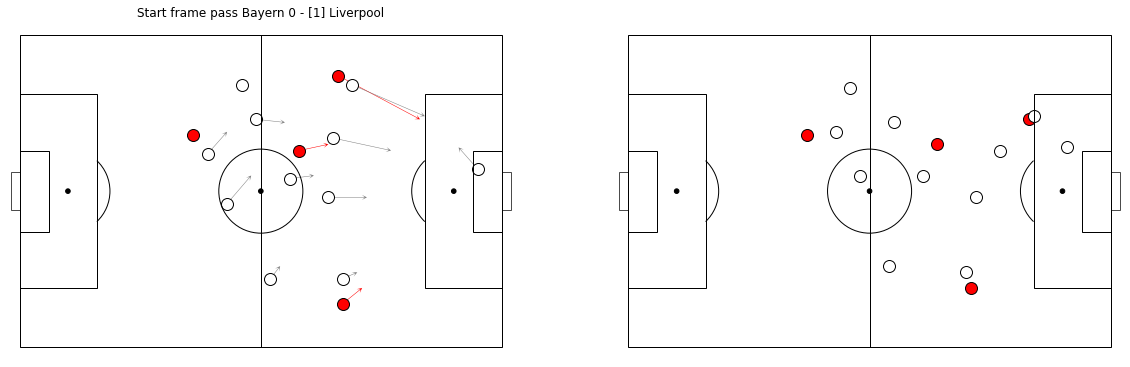

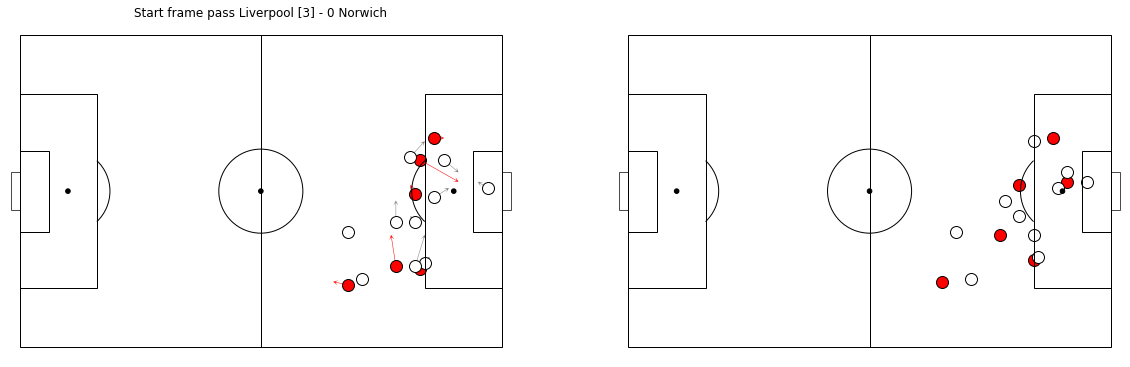

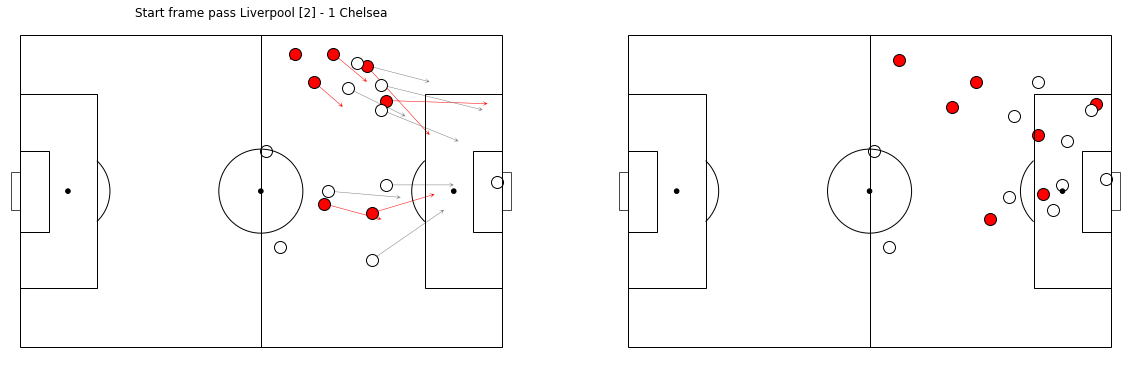

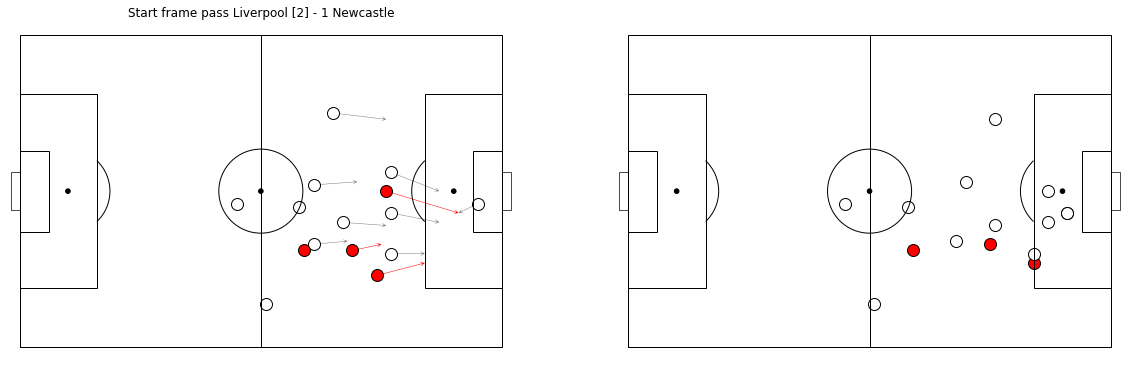

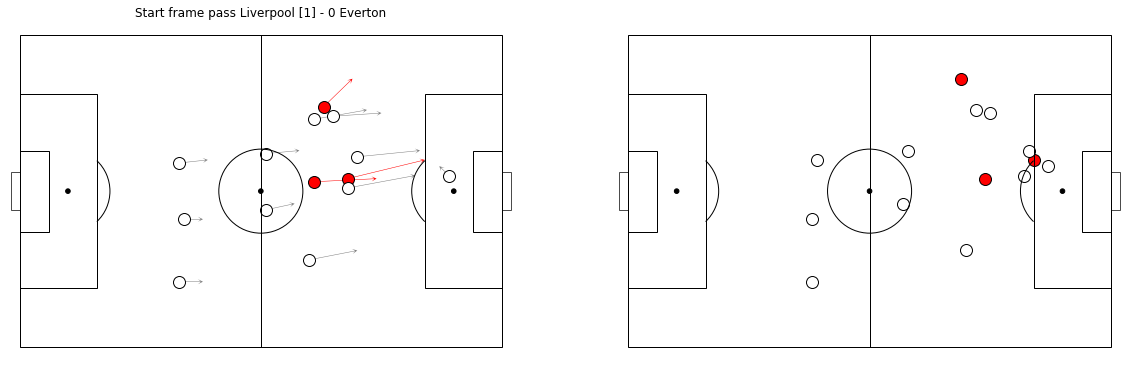

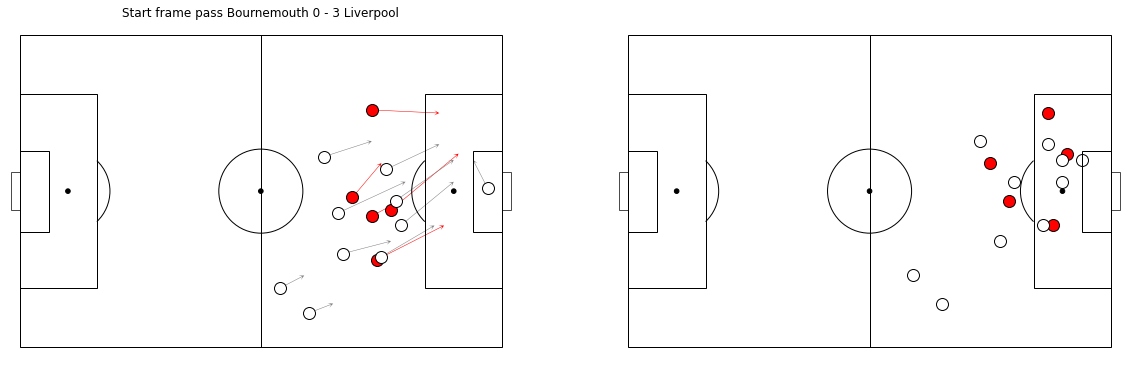

In [96]:
for id, row in custom_event_data_df[(custom_event_data_df.isThroughPass)&(custom_event_data_df.isLongPass)].iterrows():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,15))
    pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=5,
                  )
    pitch.draw(axes[0])
    pitch.draw(axes[1])
    axes[0].set_title('Start frame pass {}'.format(row['play']))
    
    # freeze shot
    freeze_frame_from = data.loc[row['play']].loc[row['from_frame']]
    freeze_frame_to = data.loc[row['play']].loc[row['to_frame']]
    
    #freeze_frame_from = data[(data.frame == row['from_frame']) & (data.play==row['play'])][['team', 'x', 'y','player_num']]
    #freeze_frame_to = data[(data.frame == row['to_frame'])& (data.play==row['play'])][['team', 'x', 'y','player_num']]
    
#     acale_to_visual2((x[0],x[1]), field_dim=(100, 100), orientation='horizontal', flip_x=x[2] < 50, flip_y=True)

    freeze_frame_from['loc'] = freeze_frame_from[['x', 'y']].apply(
        lambda x: scale_to_visual2((x[0], x[1]), field_dim=(100, 100), orientation='horizontal',
                                  flip_x=row['attack_direction'] < 50,flip_y=row['attack_direction'] > 50), axis=1) 
    freeze_frame_to['loc'] = freeze_frame_to[['x', 'y']].apply(
        lambda x: scale_to_visual2((x[0], x[1]), field_dim=(100, 100), orientation='horizontal',
                                  flip_x=row['attack_direction'] < 50,flip_y=row['attack_direction'] > 50), axis=1)
    
    team_liverpool = freeze_frame_from[freeze_frame_from.team == 'attack'].dropna()
    team_opponent = freeze_frame_from[freeze_frame_from.team == 'defense']
    
   
    pitch.plot([x[0] for x in team_liverpool['loc']], [x[1] for x in team_liverpool['loc']],
               marker='o', color='None',
               markerfacecolor='red',
               markersize=12, alpha=1,
               linestyle='None', ax=axes[0])
    pitch.plot([x[0] for x in team_opponent['loc']], [x[1] for x in team_opponent['loc']],
               marker='o', color='None',
               markerfacecolor='white',
               markersize=12, alpha=1,
               linestyle='None', ax=axes[0])
    
    ball = freeze_frame_to[freeze_frame_to.player==0]
    
#     pitch.lines(
#                 row['to_loc'][0],row['to_loc'][1],
#                 row['from_loc'][0],row['from_loc'][1],
#                 lw=10,
#                 transparent=True,comet=True,zorder=3,
#                 ax=axes[0])
#     .quiver(ax[x[0] for x in ball['loc']], [x[1] for x in ball['loc']],
#                  [x[0] for x in ball['loc']], [x[1] for x in ball['loc']],
#              width = 1,
#              headwidth = 10, headlength = 10, 
#              color = 'black',
#              linestyle ='-',
#             ax=axes[0],
#             )
    pitch.plot([x[0] for x in ball['loc']],[x[1] for x in ball['loc']],ax=axes[1],zorder=8)
    
    
    #second plot
    team_liverpool2 = freeze_frame_to[freeze_frame_to.team == 'attack'].dropna()
    team_opponent2 = freeze_frame_to[freeze_frame_to.team == 'defense']
    
    pitch.plot([x[0] for x in team_liverpool2['loc']], [x[1] for x in team_liverpool2['loc']],
               marker='o', color='None',
               markerfacecolor='red',
               markersize=12, alpha=1,
               linestyle='None', ax=axes[1])
    pitch.plot([x[0] for x in team_opponent2['loc']], [x[1] for x in team_opponent2['loc']],
               marker='o', color='None',
               markerfacecolor='white',
               markersize=12, alpha=1,
               linestyle='None', ax=axes[1])
    
    
    pitch.quiver([x[0] for x in team_liverpool['loc']], [x[1] for x in team_liverpool['loc']],
                 [x[0] for x in team_liverpool2['loc']], [x[1] for x in team_liverpool2['loc']],
             width = 0.5,
             headwidth = 10, headlength = 10, 
             color = 'red',
             linestyle ='-',
            ax=axes[0],
            )
    pitch.quiver([x[0] for x in team_opponent['loc']], [x[1] for x in team_opponent['loc']],
                 [x[0] for x in team_opponent2['loc']], [x[1] for x in team_opponent2['loc']],
             width = 0.5,
             headwidth = 10, headlength = 10, 
             color = 'grey',
             linestyle ='-',
            ax=axes[0],
            )
    
    

# Counterattacks

In [1465]:
events_org[(events_org.counter_attack) & (events_org.subEventName=='Shot')].goal.value_counts()

False    29
True      7
Name: goal, dtype: int64

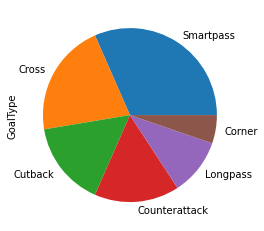

In [1876]:
extra_data[['GoalType','play']].drop_duplicates()['GoalType'].value_counts().plot(kind='pie')

# Dribles

In [689]:
dribbles_df = events_org[(events_org.subEventName=='Ground attacking duel')]
liverpool_dribbles_sub = dribbles_df.merge(players_df[['shortName','wyId']],right_on='wyId',left_on='playerId')
liverpool_dribbles_sub = liverpool_dribbles_sub[liverpool_dribbles_sub.start_x>50]
liverpool_dribbles_sub = liverpool_dribbles_sub[liverpool_dribbles_sub.end_x>50]
liverpool_dribbles_sub_left = liverpool_dribbles_sub[liverpool_dribbles_sub.take_on_left]
liverpool_dribbles_sub_right = liverpool_dribbles_sub[liverpool_dribbles_sub.take_on_left]
# liverpool_dribbles_sub['loc_end'] = liverpool_dribbles_sub[['end_x', 'end_y']].apply(lambda x: scale_to_visual(x, scale=(100, 100), field_dim=(105, 68), to_single_direction=False, orientation='horizontal'), axis=1)

The following kwargs were not used by contour: 'n_snilevels'


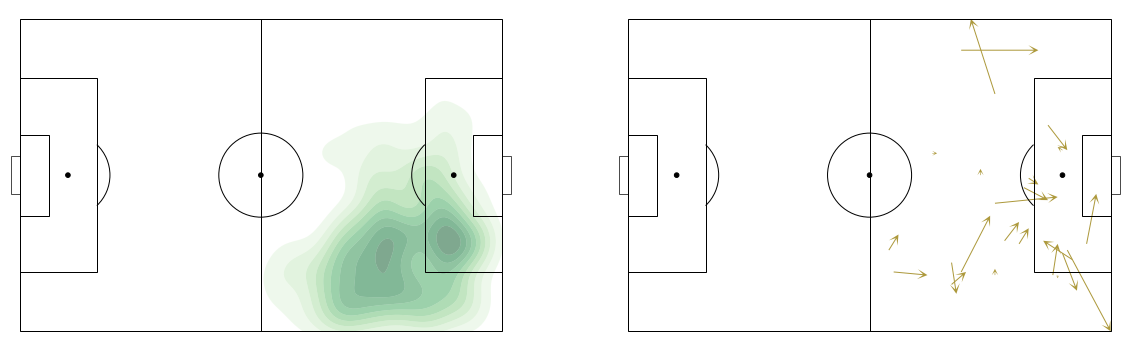

In [690]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,20))
pitch = Pitch(pitch_type='wyscout', orientation='horizontal',
                  pitch_color='white', line_color='black', goal_type='box', linewidth=1, line_zorder=5,
                  )
pitch.draw(axes[0])
pitch.draw(axes[1])

name = 'Mohamed Salah'
#Passes
pitch.kdeplot(
            [x for x in liverpool_dribbles_sub[liverpool_dribbles_sub.shortName==name]['start_x']], 
           [x for x in liverpool_dribbles_sub[liverpool_dribbles_sub.shortName==name]['start_y']],  
           shade=True, cmap="Greens",
            shade_lowest=False, n_snilevels=20, alpha=0.5, antialiased=True,
            cbar_kws={'orientation': 'horizontal', 'use_gridspec': True, 'fraction': 0.068, 'ticks': []
            },
          ax=axes[0],
)


# pitch.lines([x[0] for x in liverpool_dribbles_sub[liverpool_dribbles_sub.shortName==name]['loc_start']],
#             [x[1] for x in liverpool_dribbles_sub[liverpool_dribbles_sub.shortName==name]['loc_start']],
#             [x[0] for x in liverpool_dribbles_sub[liverpool_dribbles_sub.shortName==name]['loc_end']],
#             [x[1] for x in liverpool_dribbles_sub[liverpool_dribbles_sub.shortName==name]['loc_end']],
#             lw=9,transparent=True,comet=True,zorder=3,
#             ax=axes[1])

pitch.quiver([x for x in liverpool_dribbles_sub_left[liverpool_dribbles_sub_left.shortName==name]['start_x']],
            [x for x in liverpool_dribbles_sub_left[liverpool_dribbles_sub_left.shortName==name]['start_y']],
            [x for x in liverpool_dribbles_sub_left[liverpool_dribbles_sub_left.shortName==name]['end_x']],
            [x for x in liverpool_dribbles_sub_left[liverpool_dribbles_sub_left.shortName==name]['end_y']],
             width = 1,
             headwidth = 10, headlength = 10, 
             color = '#ad993c', label = 'dribbles',
             linestyle ='-',
            ax=axes[1]
            )